<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/master/assets/free_polynomial_monster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
%matplotlib inline

In [65]:
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interactive, BoundedIntText, BoundedFloatText
from tqdm.auto import tqdm
import cvxpy as cp
from functools import partial

In [66]:
dpi = 125
fig_width = 640 / dpi
fig_height = 480 / dpi

figsize = (fig_width, fig_height)
double_figsize = (2 * fig_width, fig_height)

mpl.rcParams['figure.dpi'] = dpi
mpl.rcParams['figure.figsize'] = figsize

# Function fitting

In [67]:
def func(x):
    z = np.cos(np.pi * x - 1) + 0.1 * np.cos(2 * np.pi * x + 1)
    return np.cbrt(np.abs(z)) * np.sign(z)

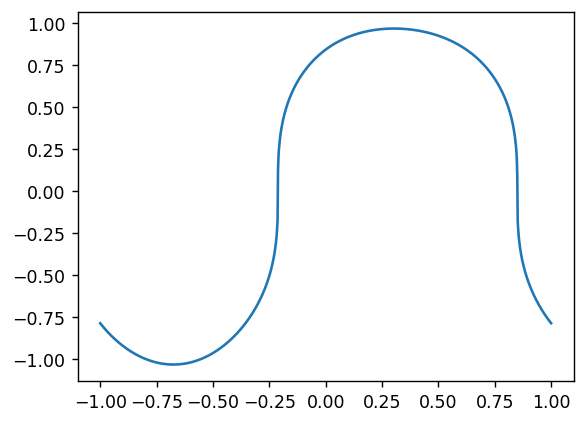

In [68]:
plot_xs = np.linspace(-1, 1, 1000)
plt.plot(plot_xs, func(plot_xs))
plt.show()

In [69]:
def noisy_func(x, noise=0.1):
    return func(x) + noise * np.random.randn(len(x))

In [70]:
np.random.seed(42)
n = 50
x = 2 * np.random.rand(n) - 1
y = noisy_func(x)

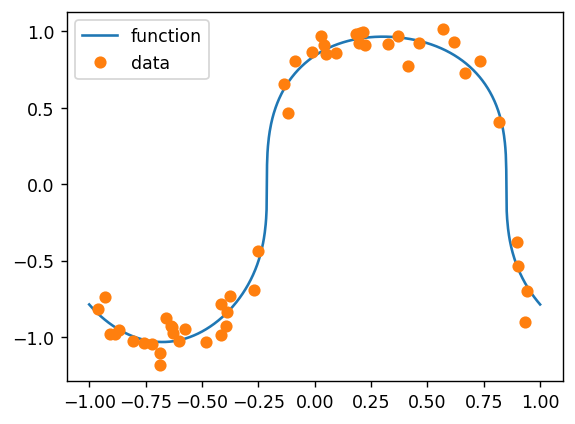

In [71]:
plt.plot(plot_xs, func(plot_xs), label='function')
plt.plot(x, y, 'o', label='data')
plt.legend()
plt.show()

In [72]:
def fit(degree, feature_matrix_fn):
    X = feature_matrix_fn(x, degree)
    poly = np.linalg.lstsq(X, y, rcond=-1)[0]
    train_rmse = np.sqrt(np.mean(np.square(X @ poly - y)))
    return poly, train_rmse


def test_fit(degree, feature_matrix_fn, coefs):
    xtest = np.linspace(-1, 1, 10000)
    ytest = feature_matrix_fn(xtest, degree) @ coefs
    test_rmse = np.sqrt(np.mean(np.square(ytest - func(xtest))))
    return xtest, ytest, test_rmse

In [73]:
def fit_cp(degree, feature_matrix_fn, bound):
    X = feature_matrix_fn(x, degree)
    poly = cp.Variable(degree + 1)
    obj = cp.Minimize(cp.norm(X @ poly - y, 2))
    prob = cp.Problem(obj, constraints=[
        cp.sum(poly) >= bound
    ])
    prob.solve()
    train_rmse = np.sqrt(np.mean(np.square(X @ poly.value - y)))
    return poly.value, train_rmse

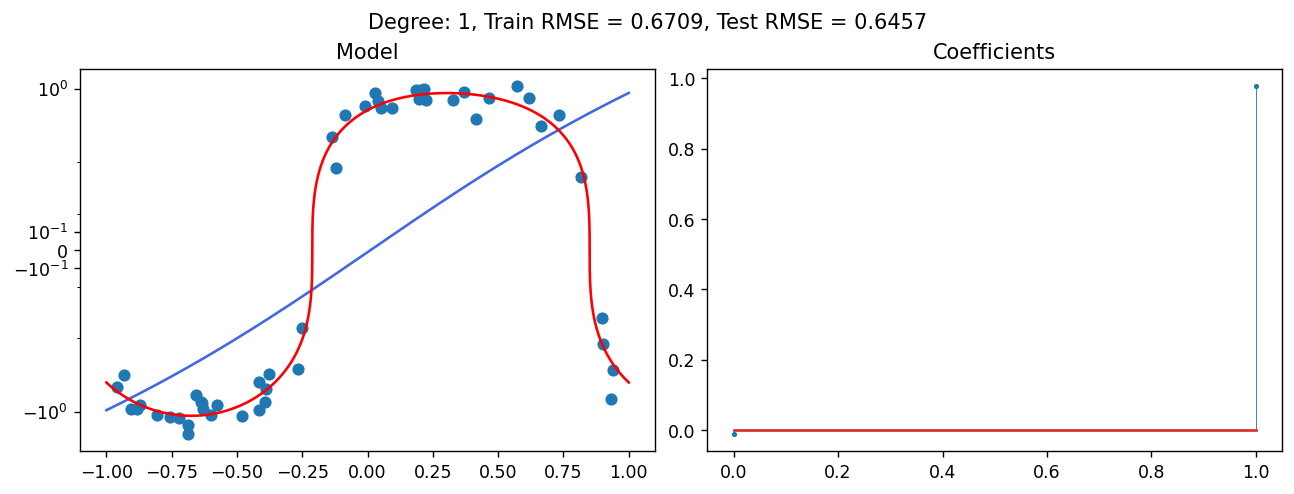

In [74]:
def fit_and_plot(degree, feature_matrix_fn):
    poly, train_rmse = fit(degree, feature_matrix_fn)
    xtest, ytest, test_rmse = test_fit(degree, feature_matrix_fn, poly)
    fig, axs = plt.subplots(1, 2, figsize=double_figsize, layout='constrained')
    fig.suptitle(f'Degree: {degree}, Train RMSE = {train_rmse:.4g}, Test RMSE = {test_rmse:.4g}')

    axs[0].scatter(x, y)
    axs[0].plot(xtest, ytest, color='royalblue')
    axs[0].plot(xtest, func(xtest), color='red')
    axs[0].set_yscale('asinh')
    axs[0].set_title('Model')

    markerline, stemlines, baseline = axs[1].stem(poly)
    stemlines.set_linewidth(0.5)
    markerline.set_markersize(2)
    axs[1].set_title('Coefficients')
    plt.show()

fit_and_plot(1, np.polynomial.polynomial.polyvander)

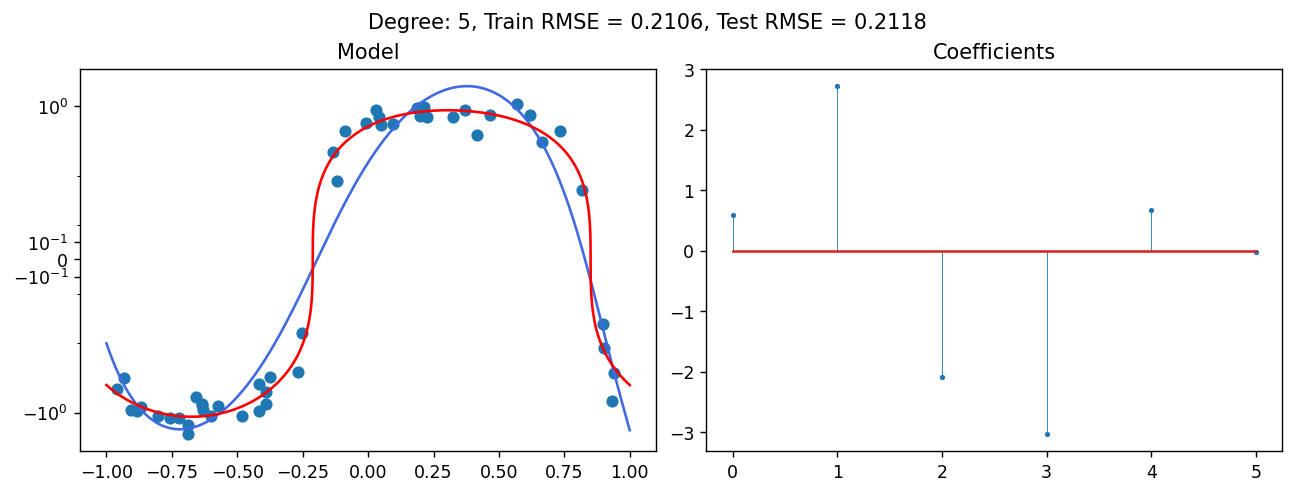

In [75]:
fit_and_plot(5, np.polynomial.polynomial.polyvander)

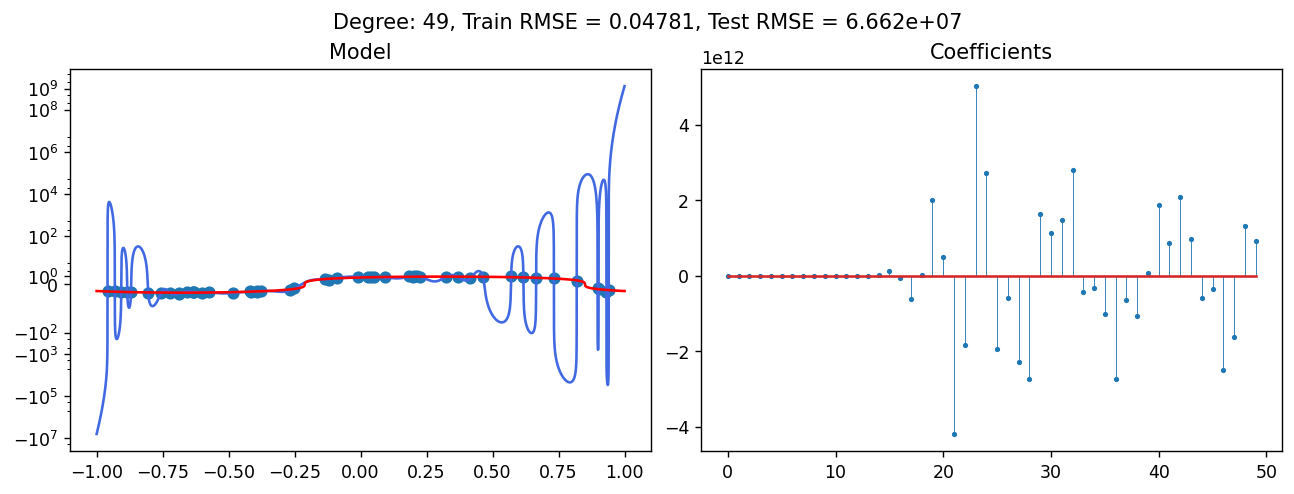

In [76]:
fit_and_plot(49, np.polynomial.polynomial.polyvander)

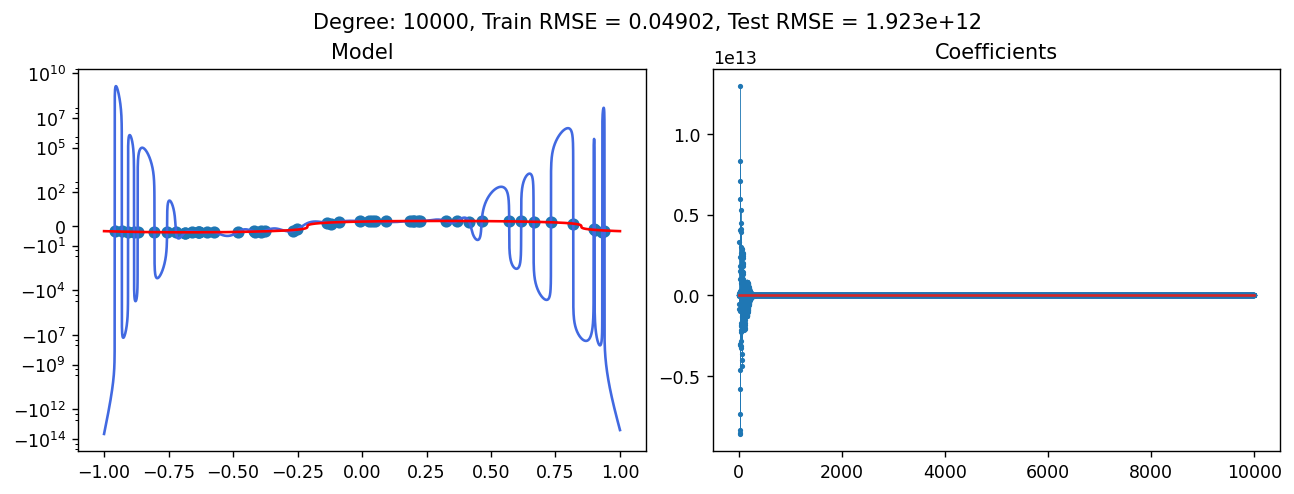

In [77]:
fit_and_plot(10000, np.polynomial.polynomial.polyvander)

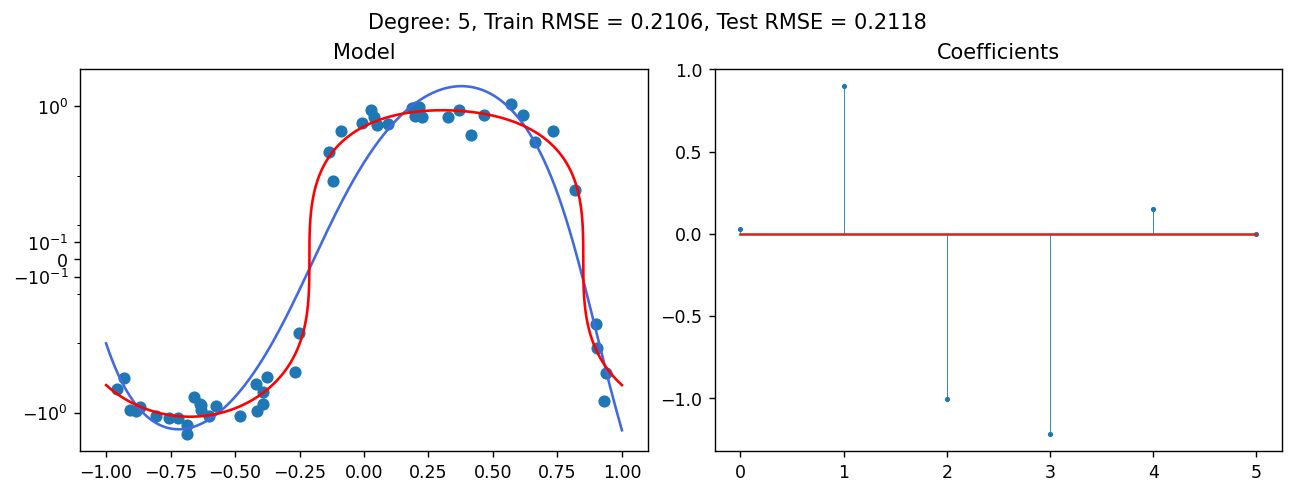

In [78]:
fit_and_plot(5, np.polynomial.legendre.legvander)

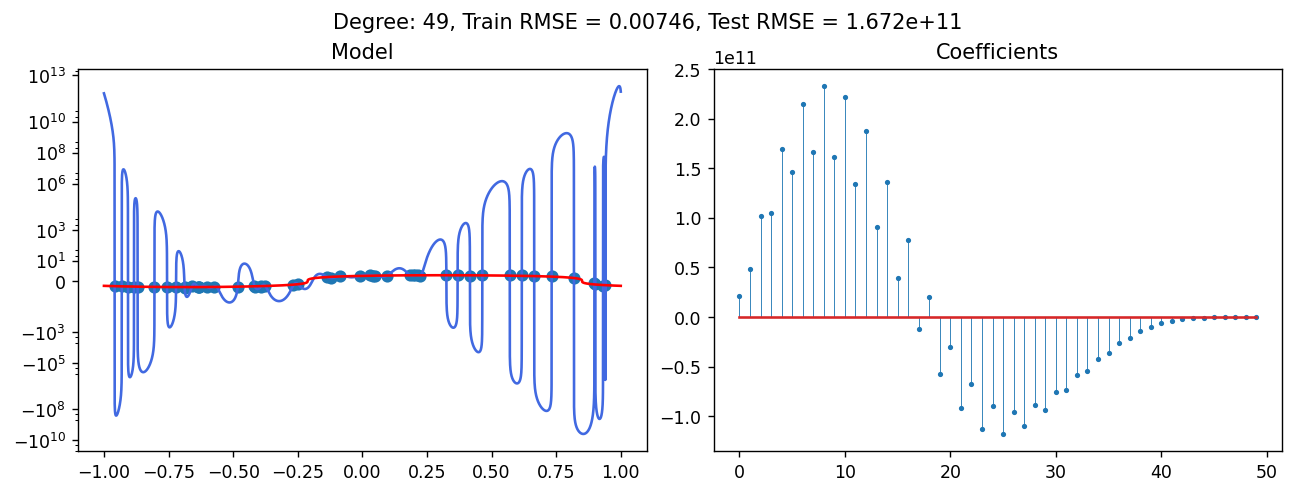

In [79]:
fit_and_plot(49, np.polynomial.legendre.legvander)

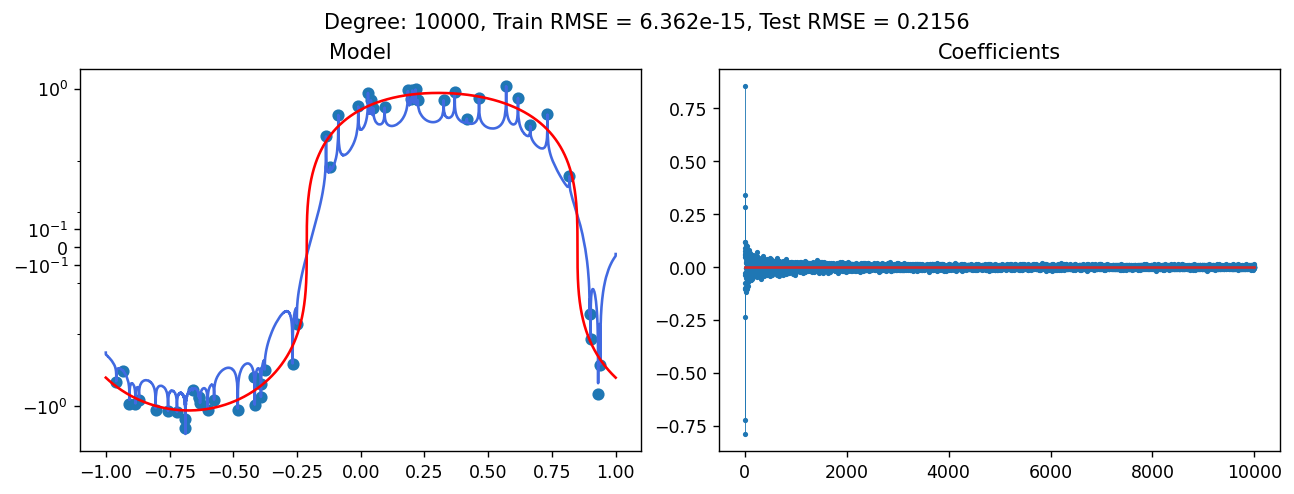

In [80]:
fit_and_plot(10000, np.polynomial.legendre.legvander)

# Truncated fit

In [81]:
def truncated_fit_plots(degree=10000,
                       truncates=[5, 10, 20, 40],
                       feature_matrix_fn=np.polynomial.legendre.legvander):
    # fit a full degree polynomial, and produce data for plotting
    poly, train_rmse = fit(degree, feature_matrix_fn)

    # data to plot of the full degree polynomial
    xtest = np.linspace(-1, 1, 10000)
    ytest = feature_matrix_fn(xtest, degree) @ poly

    # create subplots for the various truncates
    n_rows = 2
    n_cols = int(math.ceil(len(truncates) / n_rows))
    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * fig_width, n_rows * fig_height),
        layout='constrained')

    # plot each truncate together with the full degree polynomial
    for trunc_deg, ax in zip(truncates, axs.flatten()):
        trunc_poly = poly[:(trunc_deg + 1)]
        ytest_truncated = feature_matrix_fn(xtest, trunc_deg) @ trunc_poly

        ax.plot(xtest, ytest, color='royalblue', label='full')
        ax.plot(xtest, ytest_truncated, color='red', label=f'truncated')
        ax.set_title(f'Truncate deg={trunc_deg}')
        handles, labels = ax.get_legend_handles_labels()

    fig.legend(handles, labels, loc='outside right upper')
    fig.show()

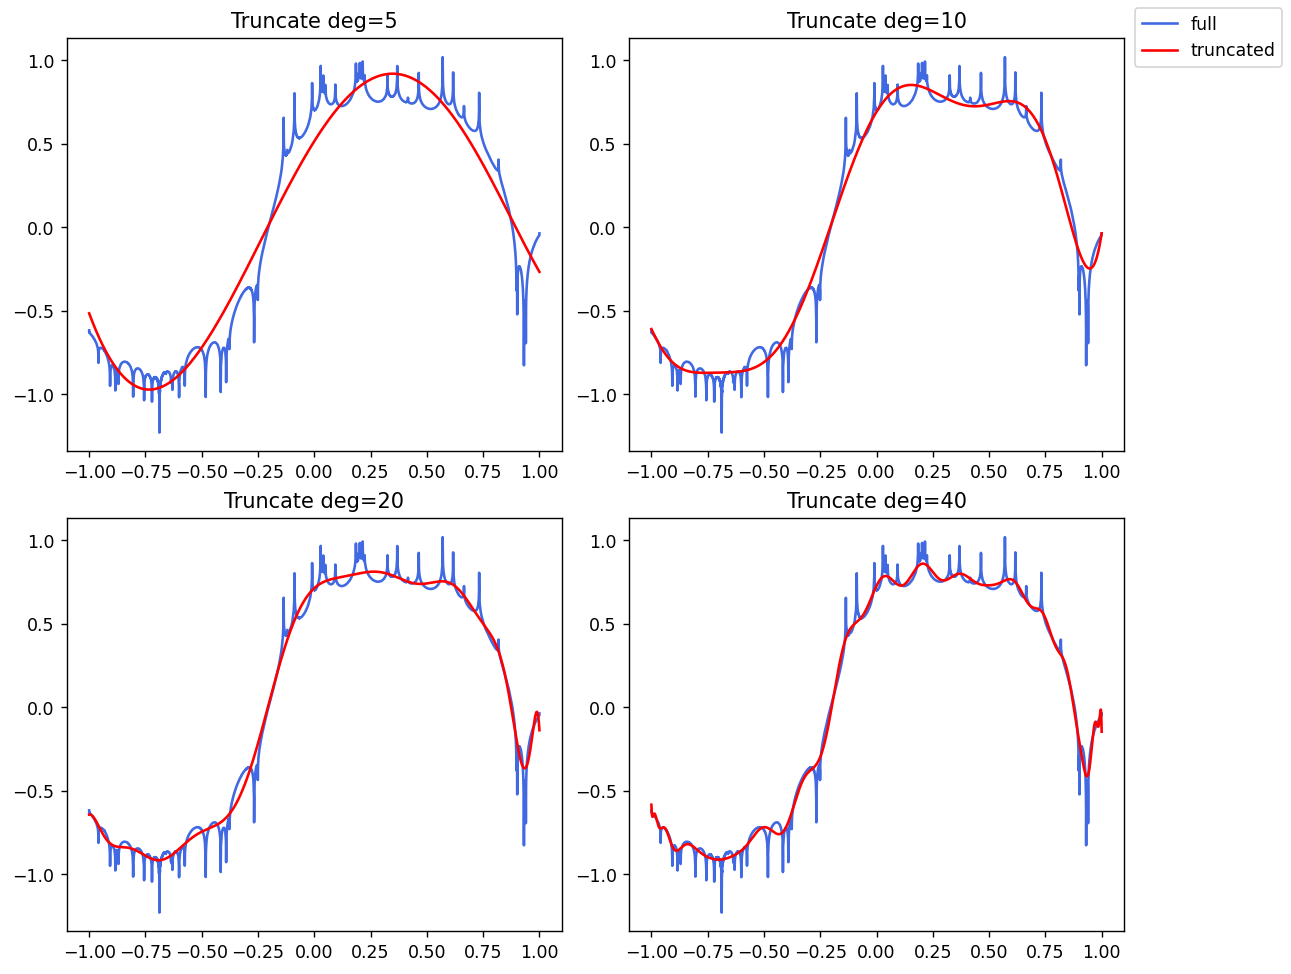

In [82]:
truncated_fit_plots()

# Plot animation

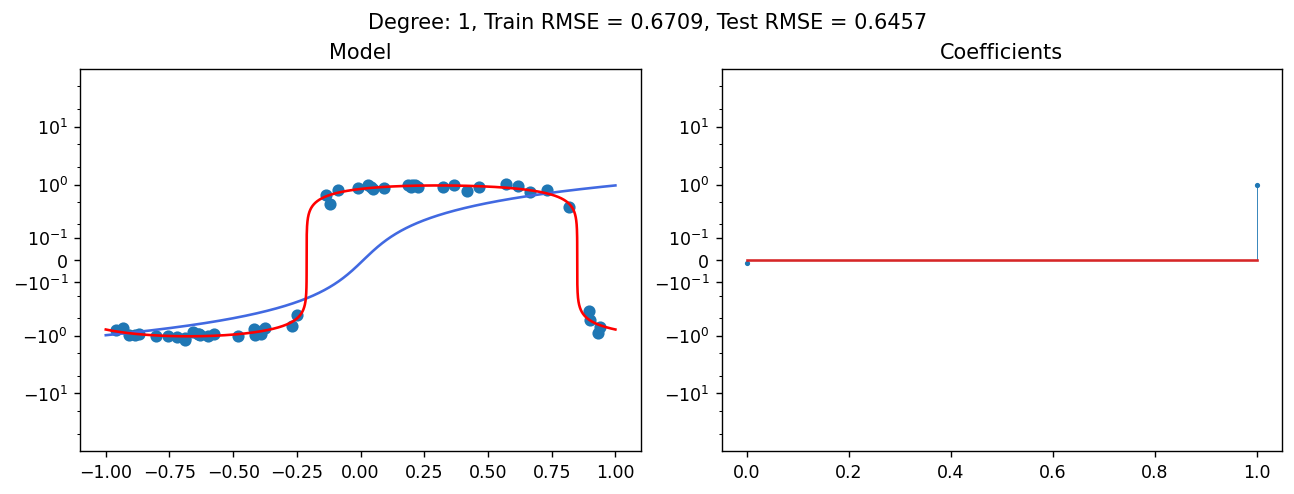

In [83]:
from matplotlib.animation import FuncAnimation, PillowWriter

degs = np.r_[
    np.sort(np.unique(np.linspace(1, n - 1, 15).astype(int))),
    np.sort(np.unique(np.geomspace(n + 1, 100000, 20).astype(int)))
]


fig, axs = plt.subplots(1, 2, figsize=double_figsize, layout='constrained')
def animate(degree):

    poly, train_rmse = fit(degree, np.polynomial.legendre.legvander)
    xtest, ytest, test_rmse = test_fit(degree, np.polynomial.legendre.legvander, poly)

    fig.suptitle(f'Degree: {degree}, Train RMSE = {train_rmse:.4g}, Test RMSE = {test_rmse:.4g}')

    axs[0].clear()
    axs[0].set_yscale('asinh', linear_width=.1)
    axs[0].set_title('Model')
    axs[0].set_ylim([-100, 100])

    axs[1].clear()
    axs[1].set_yscale('asinh', linear_width=.1)
    axs[1].set_title('Coefficients')
    axs[1].set_ylim([-100, 100])

    data_plt = axs[0].scatter(x, y)
    test_plt = axs[0].plot(xtest, ytest, color='royalblue')
    func_plt = axs[0].plot(xtest, func(xtest), color='red')

    markerline, stemlines, baseline = axs[1].stem(poly)
    stemlines.set_linewidth(0.5)
    markerline.set_markersize(2)
    return data_plt, test_plt, func_plt, markerline, baseline, stemlines

ani = FuncAnimation(fig, animate, degs)
ani.save('degrees.gif', dpi=300, writer=PillowWriter(fps=2.5))

# Error curves

In [84]:
def plot_errors(feature_matrix_fn):
    # define a set of degrees that look nice in a plot - linearly spaced
    # low degrees, and geometrically spaced high degrees.
    degs = np.r_[
        np.sort(np.unique(np.linspace(1, n - 1, 15).astype(int))),
        np.sort(np.unique(np.geomspace(n+1, 100000, 20).astype(int)))
    ]

    # compute train and test errors
    train_errors = np.zeros_like(degs).astype(float)
    test_errors = np.zeros_like(degs).astype(float)
    for i, deg in enumerate(tqdm(degs)):
        poly, train_errors[i] = fit(deg, feature_matrix_fn)
        _, _, test_errors[i] = test_fit(deg, feature_matrix_fn, poly)

    # plot the train and test errors, and the interpolation threshold vertical
    # bar.
    plt.figure(figsize=double_figsize, layout='constrained')
    plt.plot(degs, train_errors, label='Train')
    plt.plot(degs, test_errors, label='Test')
    plt.axvline(n - 1, color='royalblue', linewidth=3, linestyle='dotted',
                alpha=0.5)
    plt.axhline(np.min(test_errors), color='olive', linewidth=1, linestyle='dashed',
                alpha=0.5, label=f'Min RMSE = {np.min(test_errors):.3g}')
    plt.ylim([-1e-3, 2 * np.max(test_errors)])
    plt.yscale('asinh', linear_width=1e-3)
    plt.xscale('log')
    plt.xlabel('Degree')
    plt.ylabel('Root Mean Squared Error')
    plt.legend()
    plt.show()

  0%|          | 0/35 [00:00<?, ?it/s]

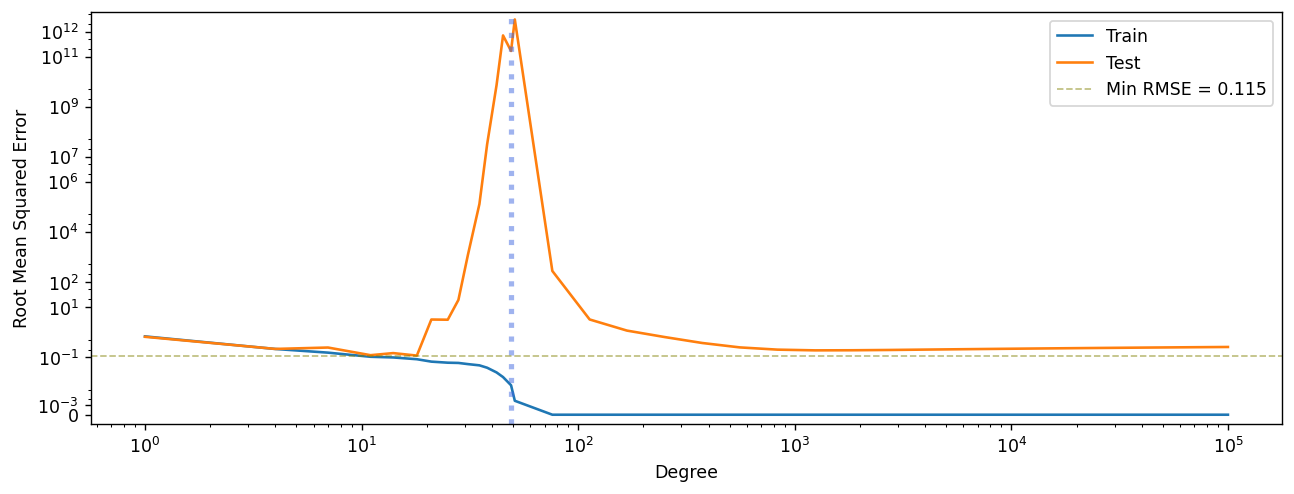

In [85]:
plot_errors(np.polynomial.legendre.legvander)

  0%|          | 0/35 [00:00<?, ?it/s]

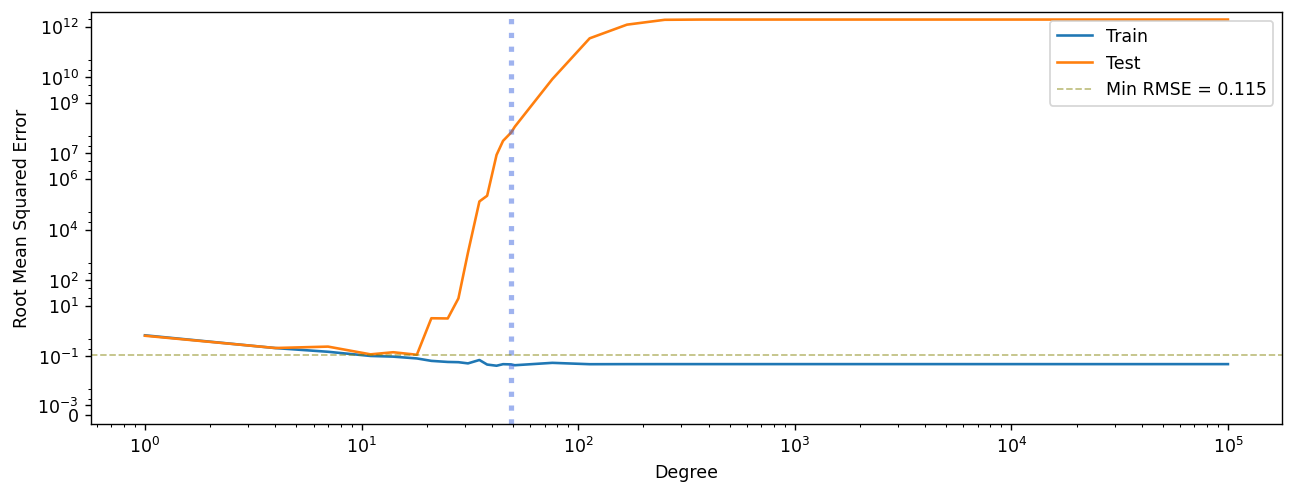

In [86]:
plot_errors(np.polynomial.polynomial.polyvander)

# Orthogonality

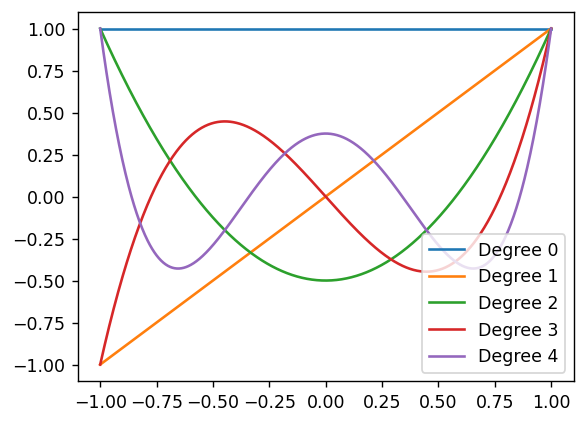

In [87]:
handles = plt.plot(plot_xs, np.polynomial.legendre.legvander(plot_xs, 4))
plt.legend(handles=handles, labels=[f'Degree {i}' for i in range(5)])
plt.show()

# Extrapolation

In [88]:
np.random.seed(42)
n = 25
x = np.random.rand(n) - 0.5
y = noisy_func(x)

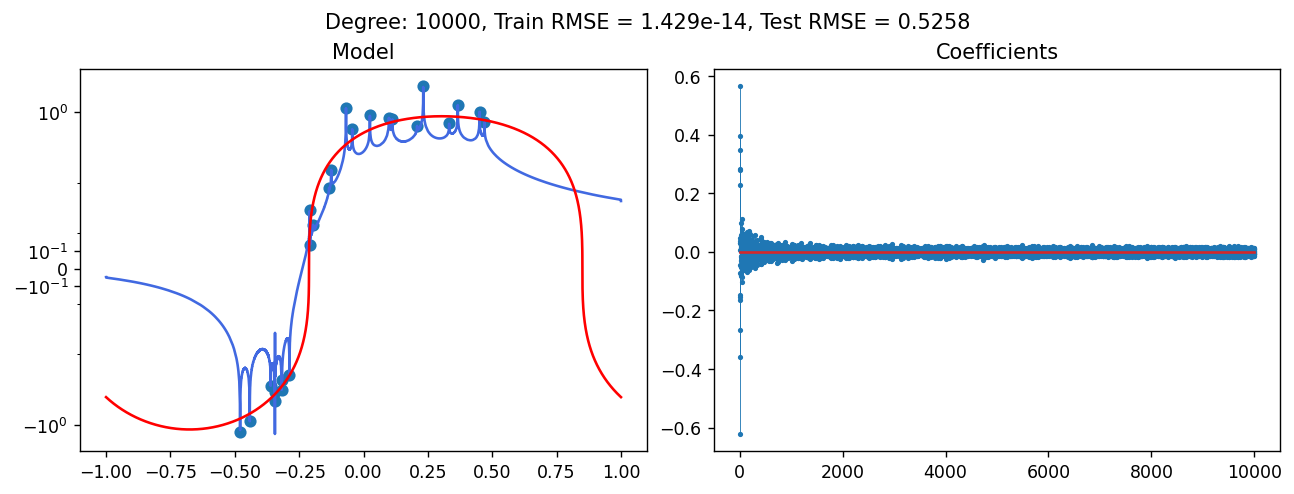

In [89]:
fit_and_plot(10000, np.polynomial.legendre.legvander)